# KL + Bayesian Compression for Wideband PSD

We model an unknown PSD vector on a frequency grid:
- Frequency grid: $\{f_i\}_{i=1}^M$
- PSD samples: $s \in \mathbb{R}^M$

We build a low-rank Karhunen–Loève (KL) representation using a positive definite frequency kernel $k_f$:

### Weighted Gram matrix (quadrature-aware)
Given quadrature weights $\{w_i\}$,
$$
[K_w]_{ij} = k_f(f_i,f_j)\sqrt{w_iw_j}.
$$

Compute the top-$R$ eigenpairs:
$$
K_w v_n = \lambda_n v_n, \quad n=1,\dots,R.
$$

Approximate eigenfunctions on the grid:
$$
\phi_n(f_i)\approx \frac{[v_n]_i}{\sqrt{w_i}}.
$$

KL feature matrix:
$$
[\Phi_{KL}]_{i,n}=\sqrt{\lambda_n}\,\phi_n(f_i).
$$

Low-rank model:
$$
s \approx \Phi_{KL}\,\xi,\quad \xi\sim\mathcal N(0,I_R).
$$

---

## Synthetic sensing model (subsampled bins)

We choose a subset of indices $\mathcal I$ (size $N$) and observe:
$$
y = \Theta s + \varepsilon,\quad \varepsilon\sim\mathcal N(0,\sigma^2 I_N),
$$
where $\Theta$ selects the PSD entries at indices $\mathcal I$. Equivalently:
$$
y = s_{\mathcal I} + \varepsilon.
$$

With $s\approx \Phi_{KL}\xi$, define:
$$
A = \Theta\Phi_{KL}\in\mathbb{R}^{N\times R},
\quad\Rightarrow\quad
y = A\xi+\varepsilon.
$$

---

## Static Bayesian linear regression posterior

$$
\Sigma_{\xi|y} = \left(I + A^\top \Sigma_\varepsilon^{-1} A\right)^{-1},\qquad
\mu_{\xi|y} = \Sigma_{\xi|y} A^\top \Sigma_\varepsilon^{-1} y.
$$

Reconstruction:
$$
\hat s = \Phi_{KL}\mu_{\xi|y}.
$$

We will also compute an approximate pointwise credible band using:
$$
\Sigma_{s|y} = \Phi_{KL}\Sigma_{\xi|y}\Phi_{KL}^\top,
\quad
\operatorname{diag}(\Sigma_{s|y})_i
=
\Phi_{KL}[i,:]\ \Sigma_{\xi|y}\ \Phi_{KL}[i,:]^\top.
$$


In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

## Kernel choice

We need a positive definite kernel on frequency.
We'll use the Matérn $\nu=3/2$ kernel (1D):

$$
k(r)=\sigma_f^2\left(1+\frac{\sqrt{3}\,r}{\ell}\right)\exp\left(-\frac{\sqrt{3}\,r}{\ell}\right),
\quad r = |f-f'|.
$$

This kernel yields smooth-but-not-overly-smooth PSD structure and is common in GP modeling.


In [15]:
def matern32_kernel_matrix(x, ell=0.08, sigma2=1.0):
    """
    Returns K where K[i,j] = k(|x_i - x_j|) for Matérn nu=3/2 kernel.
    x: (M,)
    """
    x = np.asarray(x)
    r = np.abs(x[:, None] - x[None, :])
    a = np.sqrt(3.0) * r / ell
    return sigma2 * (1.0 + a) * np.exp(-a)

## KL basis construction (offline)

We implement exactly:

$$
K_w = \operatorname{diag}(\sqrt{w})\ K\ \operatorname{diag}(\sqrt{w})
$$
where $K_{ij}=k_f(f_i,f_j)$.

Then:
- Eigendecompose $K_w$
- Convert eigenvectors $v_n$ to grid eigenfunctions $\phi_n(f_i)\approx v_{n,i}/\sqrt{w_i}$
- Form $\Phi_{KL}[i,n]=\sqrt{\lambda_n}\phi_n(f_i)$

This $\Phi_{KL}$ is the "compression dictionary".


In [16]:
def build_phi_kl(f, w, kernel_matrix, R):
    """
    f: (M,) grid
    w: (M,) quadrature weights >0
    kernel_matrix: (M,M) with K_ij = k(f_i,f_j)
    R: rank
    
    Returns:
      Phi_KL: (M,R)
      lam: (R,) eigenvalues
    """
    f = np.asarray(f)
    w = np.asarray(w)
    M = f.size
    sqrtw = np.sqrt(w)

    # Weighted Gram matrix
    Kw = (sqrtw[:, None] * kernel_matrix) * sqrtw[None, :]

    # Symmetric eigendecomposition (ascending)
    evals, evecs = np.linalg.eigh(Kw)
    idx = np.argsort(evals)[::-1]   # descending
    evals = evals[idx]
    evecs = evecs[:, idx]

    lam = evals[:R].copy()
    V = evecs[:, :R].copy()

    # Guard small negatives from numeric error
    lam[lam < 0] = 0.0

    # phi_n(f_i) ≈ v_n[i] / sqrt(w_i)
    Phi = V / sqrtw[:, None]        # (M,R)

    # Phi_KL[i,n] = sqrt(lam_n) * phi_n(f_i)
    Phi_KL = Phi * np.sqrt(lam)[None, :]

    return Phi_KL, lam

## Synthetic data generation

We generate:
1) Latent KL coefficients: $\xi_{\text{true}}\sim\mathcal N(0,I_R)$
2) PSD on the grid: $s_{\text{true}}=\Phi_{KL}\xi_{\text{true}}$

Then choose a set of observed indices $\mathcal I$ and measure:
$$
y = s_{\text{true},\mathcal I} + \varepsilon,\quad \varepsilon\sim\mathcal N(0,\sigma^2 I).
$$

We set $\sigma^2$ using a target SNR on the measured vector $y$:
$$
\text{SNR} = \frac{\mathbb E\|y_{\text{clean}}\|^2}{\mathbb E\|\varepsilon\|^2}.
$$

In [17]:
def choose_subsample_indices(M, N, rng, mode="uniform"):
    """
    Pick N indices from {0,...,M-1}.
    mode="uniform": uniform random sampling
    mode="jittered": roughly uniform coverage (stratified)
    """
    if N > M:
        raise ValueError("N must be <= M")

    if mode == "uniform":
        idx = rng.choice(M, size=N, replace=False)
        idx.sort()
        return idx

    if mode == "jittered":
        # stratify into N bins and pick one from each bin (good coverage)
        edges = np.linspace(0, M, N + 1).astype(int)
        idx = []
        for k in range(N):
            lo, hi = edges[k], max(edges[k] + 1, edges[k+1])
            idx.append(rng.integers(lo, hi))
        idx = np.array(idx, dtype=int)
        idx = np.unique(idx)
        # If duplicates reduced count, fill with random extras
        if idx.size < N:
            missing = N - idx.size
            candidates = np.setdiff1d(np.arange(M), idx)
            extra = rng.choice(candidates, size=missing, replace=False)
            idx = np.sort(np.concatenate([idx, extra]))
        else:
            idx.sort()
        return idx

    raise ValueError("mode must be 'uniform' or 'jittered'")

def generate_synthetic_psd_and_measurements(
    f, w, Phi_KL, R, N, snr_db, seed=0, sampling="jittered"
):
    rng = np.random.default_rng(seed)
    M = f.size

    # True latent coefficients and PSD
    xi_true = rng.normal(size=R)
    s_true = Phi_KL @ xi_true

    # Choose observed indices
    I = choose_subsample_indices(M, N, rng, mode=sampling)

    # Measurements: y = s[I] + noise
    y_clean = s_true[I]
    sig_pow = np.mean(y_clean**2)
    snr_lin = 10 ** (snr_db / 10.0)
    sigma2 = sig_pow / snr_lin

    noise = rng.normal(scale=np.sqrt(sigma2), size=N)
    y = y_clean + noise

    return xi_true, s_true, I, y_clean, y, sigma2

## Bayesian inference in the compressed space

With subsampling operator $\Theta$, the regression matrix is:

$$
A = \Theta\Phi_{KL}.
$$

For pure subsampling, $A$ is simply the row-subset of $\Phi_{KL}$:
$$
A = \Phi_{KL}[\mathcal I,:].
$$

Posterior (with $\Sigma_\varepsilon=\sigma^2I$):

$$
\Sigma_{\xi|y} = \left(I + \frac{1}{\sigma^2}A^\top A\right)^{-1},\quad
\mu_{\xi|y} = \Sigma_{\xi|y}\frac{1}{\sigma^2}A^\top y.
$$

We'll implement this with Cholesky solves (no explicit matrix inverse).

In [18]:
def infer_xi_static_subsample(y, Phi_KL, I, sigma2):
    """
    y: (N,)
    Phi_KL: (M,R)
    I: (N,) observed indices
    sigma2: noise variance, eps~N(0,sigma2 I)

    Returns:
      mu_xi: (R,)
      Sigma_xi: (R,R)
    """
    A = Phi_KL[I, :]  # (N,R)
    R = A.shape[1]

    G = np.eye(R) + (A.T @ A) / sigma2
    b = (A.T @ y) / sigma2

    L = np.linalg.cholesky(G)
    tmp = np.linalg.solve(L, b)
    mu_xi = np.linalg.solve(L.T, tmp)

    # Sigma_xi = inv(G)
    I_R = np.eye(R)
    tmp2 = np.linalg.solve(L, I_R)
    Sigma_xi = np.linalg.solve(L.T, tmp2)

    return mu_xi, Sigma_xi

## Experiment configuration

We'll run one full experiment:
- Build frequency grid and weights
- Construct $\Phi_{KL}$
- Generate synthetic PSD + subsampled noisy measurements
- Infer $\hat\xi$ and reconstruct $\hat s$
- Plot with sampled points overlaid

In [19]:
# ---- Config ----
M = 512          # number of frequency grid points
R = 40           # KL rank
N = 120          # number of observed points
snr_db = 10.0    # SNR on measured y
seed = 7

# Frequency grid and quadrature weights
f = np.linspace(0.0, 1.0, M)
df = f[1] - f[0]
w = np.full(M, df)

# Kernel matrix on grid
K = matern32_kernel_matrix(f, ell=0.08, sigma2=1.0)

# Build KL basis
Phi_KL, lam = build_phi_kl(f, w, K, R)

# Synthetic data + measurements
xi_true, s_true, I, y_clean, y, sigma2 = generate_synthetic_psd_and_measurements(
    f, w, Phi_KL, R, N, snr_db, seed=seed, sampling="jittered"
)

# Inference
xi_hat, Sigma_xi = infer_xi_static_subsample(y, Phi_KL, I, sigma2)
s_hat = Phi_KL @ xi_hat

# Metrics
mse_s = np.mean((s_hat - s_true)**2)
nmse_s = np.sum((s_hat - s_true)**2) / (np.sum(s_true**2) + 1e-12)
mse_xi = np.mean((xi_hat - xi_true)**2)

print("---- Results ----")
print(f"MSE(s):   {mse_s:.4e}")
print(f"NMSE(s):  {nmse_s:.4e}")
print(f"MSE(xi):  {mse_xi:.4e}")
print(f"sigma^2:  {sigma2:.4e}")
print(f"Observed N={N} out of M={M} points")


---- Results ----
MSE(s):   6.8784e-03
NMSE(s):  1.9497e-02
MSE(xi):  1.2038e-01
sigma^2:  3.5094e-02
Observed N=120 out of M=512 points


## Visualization: reconstruction + sampled points

We will plot:
- True PSD $s_{\text{true}}$ as a line
- Reconstructed PSD $\hat s$ as a dashed line
- Observed sample points $(f_i, y_i)$ as markers at the sampled indices $\mathcal I$

Note: $y_i$ are noisy measurements of the PSD at those indices (since $\Theta$ is subsampling).

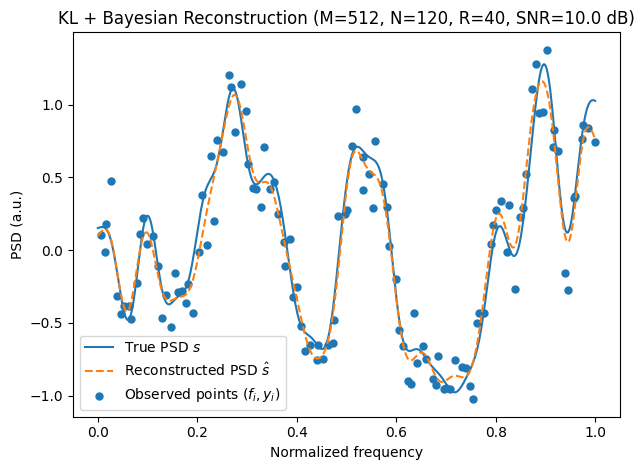

In [20]:
plt.figure()
plt.plot(f, s_true, label="True PSD $s$", linewidth=1.5)
plt.plot(f, s_hat, label="Reconstructed PSD $\hat{s}$", linestyle="--", linewidth=1.5)

# Overlay sampled points used in reconstruction
plt.scatter(f[I], y, label="Observed points $(f_i, y_i)$", marker="o", s=25)

plt.title(f"KL + Bayesian Reconstruction (M={M}, N={N}, R={R}, SNR={snr_db} dB)")
plt.xlabel("Normalized frequency")
plt.ylabel("PSD (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

## Posterior uncertainty (approx. pointwise band)

The posterior covariance in PSD space is:
$$
\Sigma_{s|y} = \Phi_{KL}\Sigma_{\xi|y}\Phi_{KL}^\top.
$$

Computing the full $M\times M$ matrix can be expensive, but we only need the diagonal:
$$
\left[\Sigma_{s|y}\right]_{ii}
= \Phi_{KL}[i,:]\ \Sigma_{\xi|y}\ \Phi_{KL}[i,:]^\top.
$$

Then a pointwise $95\%$ band is:
$$
\hat s_i \pm 1.96\sqrt{\left[\Sigma_{s|y}\right]_{ii}}.
$$

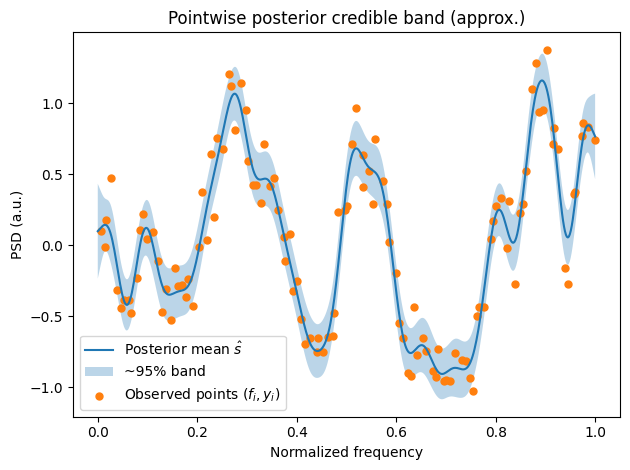

In [21]:
# Efficient diagonal of Sigma_s
diag_Sigma_s = np.einsum("ir,rq,iq->i", Phi_KL, Sigma_xi, Phi_KL)
std_s = np.sqrt(np.maximum(diag_Sigma_s, 0.0))
z = 1.96

plt.figure()
plt.plot(f, s_hat, label="Posterior mean $\hat{s}$", linewidth=1.5)
plt.fill_between(f, s_hat - z * std_s, s_hat + z * std_s, alpha=0.3, label="~95% band")

# Show observed points again
plt.scatter(f[I], y, label="Observed points $(f_i, y_i)$", marker="o", s=25)

plt.title("Pointwise posterior credible band (approx.)")
plt.xlabel("Normalized frequency")
plt.ylabel("PSD (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()

## (Optional) Diagnostics: energy captured by the first R KL modes

A practical choice of rank is based on cumulative explained variance:
$$
\frac{\sum_{n=1}^R \lambda_n}{\sum_{n=1}^M \lambda_n}\in[0.95,0.99].
$$

We'll plot the cumulative ratio.

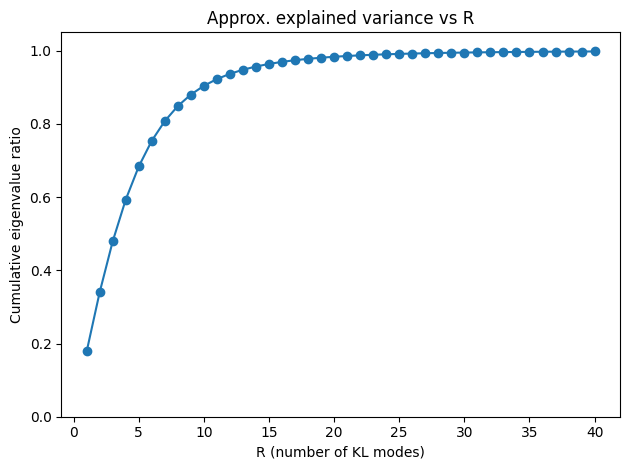

Cumulative ratio at R=40: 0.9978


In [22]:
# Compute full spectrum quickly (already have it if we kept all evals; here approximate using top-R only)
# For a more accurate denominator, you'd eigendecompose with larger rank or use trace(Kw)=sum(lambda_n).
# For Mercer operators, trace approx is sum of all eigenvalues of Kw (numerically).
# We'll estimate trace using np.trace(Kw) computed without storing Kw separately by using weights.

# Exact trace of Kw:
sqrtw = np.sqrt(w)
Kw_trace = np.trace((sqrtw[:, None] * K) * sqrtw[None, :])

cum = np.cumsum(lam)
ratio = cum / (Kw_trace + 1e-12)

plt.figure()
plt.plot(np.arange(1, R + 1), ratio, marker="o")
plt.ylim(0, 1.05)
plt.xlabel("R (number of KL modes)")
plt.ylabel("Cumulative eigenvalue ratio")
plt.title("Approx. explained variance vs R")
plt.tight_layout()
plt.show()

print(f"Cumulative ratio at R={R}: {ratio[-1]:.4f}")
